In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))
emme_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration','emme_configuration.toml'))
network_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration','network_configuration.toml'))

# create connection
conn = create_engine('sqlite:///inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## daily traffic counts

In [2]:
df = pd.read_csv(os.path.join(csv_path, 'daily_volume.csv'))
df[['modeled', 'observed']] = df[['modeled', 'observed']].astype('float')
_df = df.groupby('@facilitytype').sum()[['observed', 'modeled']]
_df.loc['Total', :] = _df.sum().values
_df['diff'] = _df['modeled'] - _df['observed']
_df['percent_diff'] = _df['diff'] / _df['observed']
_df[['percent_diff']] = _df[['percent_diff']].applymap(format_percent)
_df

,observed,modeled,diff,percent_diff
@facilitytype,,,,
Arterial,"542,504.00","600,001.00","57,497.00",10.60%
Freeway,"37,032,895.00","37,547,599.00","514,704.00",1.39%
HOV,"246,053.00","298,805.00","52,752.00",21.44%
Ramp,"93,532.00","64,603.00","-28,929.00",-30.93%
Total,"37,914,984.00","38,511,008.00","596,024.00",1.57%


In [3]:
df = pd.read_csv(os.path.join(csv_path,'daily_volume_county_facility.csv'))
df[['modeled','observed']] = df[['modeled','observed']].astype('float')

_df = df.groupby('county').sum()[['observed','modeled']]
_df.loc['Total',:] = _df.sum().values
_df['diff'] = _df['modeled']-_df['observed']
_df['percent_diff'] = _df['diff']/_df['observed']
_df[['percent_diff']] = _df[['percent_diff']].applymap(format_percent)
_df

,observed,modeled,diff,percent_diff
county,,,,
King,"23,387,201.00","24,123,584.00","736,383.00",3.15%
Pierce,"7,656,941.00","7,620,307.00","-36,634.00",-0.48%
Snohomish,"6,870,842.00","6,767,117.00","-103,725.00",-1.51%
Total,"37,914,984.00","38,511,008.00","596,024.00",1.57%


## daily traffic scatterplot

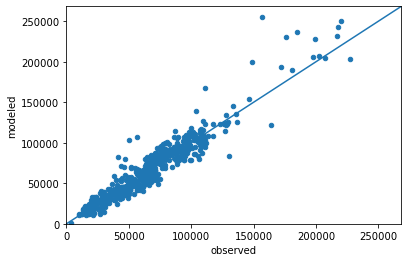

In [4]:
df = pd.read_csv(os.path.join(csv_path,'daily_volume.csv'))
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)

In [5]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2: ' + str(r_value))

r^2: 0.9549586035459601


King r^2: 0.9605949423913568
Pierce r^2: 0.9451783712835409
Snohomish r^2: 0.9379505436727711


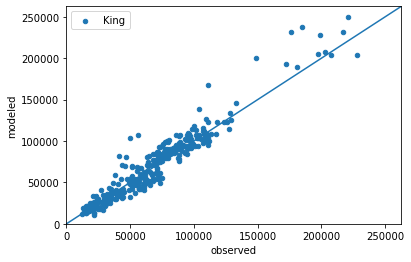

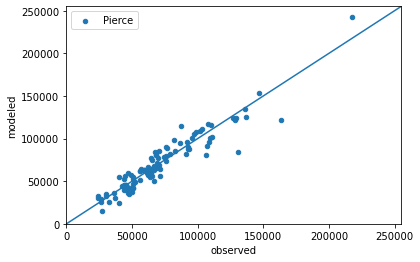

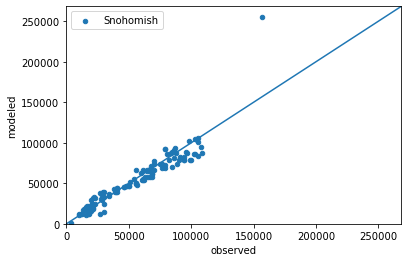

In [6]:
for county in np.unique(df['county']):
    _df = df[df['county'] == county]
    ax = _df.plot(kind='scatter', x='observed', y='modeled', label=county)
    lim = _df[['observed','modeled']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed'],_df['modeled'])
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    print(str(county) + ' r^2: ' + str(r_value))

In [7]:
df['@facilitytype'].unique()

array(['Freeway', 'Ramp', 'HOV', 'Arterial'], dtype=object)

r^2 Freeway: 0.9532121798091191


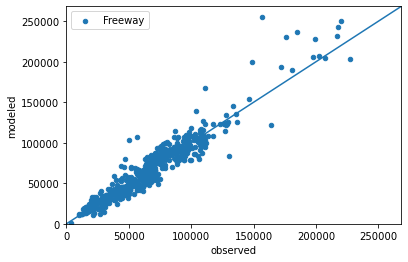

In [8]:
# for factype in ['Freeway','Arterial']:
for factype in ['Freeway']:
    _df = df[df['@facilitytype'] == factype]
    ax = _df.plot(kind='scatter', x='observed', y='modeled', label=factype)
    lim = _df[['observed','modeled']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed'],_df['modeled'])
    print('r^2 ' + str(factype) + ': ' + str(r_value))

In [9]:
## hourly volumnes

In [10]:
# df = pd.read_csv(os.path.join(csv_path,'hourly_volume.csv'))
# ax = df.plot(kind='scatter', x='observed', y='modeled')
# lim = df[['observed','modeled']].max().max()*1.05
# ax.set_ylim(0,lim)
# ax.set_xlim(0,lim)
# x = np.linspace(*ax.get_xlim())
# ax.plot(x, x)
# slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
# print('r^2: ' + str(r_value))

## screenlines

In [11]:
df = pd.read_csv(os.path.join(csv_path,'screenlines.csv'))
df = df.append(df.sum(numeric_only=True), ignore_index=True)
df.at[df.index[-1], 'name'] = 'TOTAL'
#df.at['C', 'name'] = 10
df['percent_diff'] = df['diff']/df['observed']
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,name,observed,modeled,county,diff,percent_diff
0,AUBURN - SOUTH KING,"592,476.00","528,628.09",King,"-63,847.91",-10.78%
1,KENT,"559,335.00","501,714.53",King,"-57,620.47",-10.30%
2,SHIP CANAL,"480,070.00","528,267.64",King,"48,197.64",10.04%
3,SEATTLE - SOUTH OF CBD,"473,322.00","501,461.02",King,"28,139.02",5.95%
4,MILL CREEK,"391,447.00","375,511.09",King,"-15,935.91",-4.07%
5,SOUTH BELLEVUE,"389,700.00","371,529.21",King,"-18,170.79",-4.66%
6,KIRKLAND-REDMOND,"381,663.00","397,846.16",King,"16,183.16",4.24%
7,SEATTLE - NORTH,"356,051.00","377,619.52",King,"21,568.52",6.06%
8,TACOMA - EAST OF CBD,"324,463.00","349,305.34",Pierce,"24,842.34",7.66%
9,PARKLAND,"299,722.00","271,628.25",Pierce,"-28,093.75",-9.37%


r^2 : 0.9867314366508045


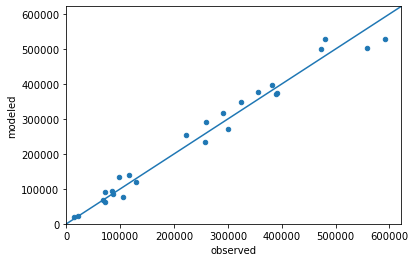

In [12]:
df = df.head(-1)
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2 : ' + str(r_value))